# Data integration and batch correction

An important task of single-cell analysis is the integration of several samples, which we can perform with omicverse. 

Here we demonstrate how to merge data using omicverse and perform a corrective analysis for batch effects. We provide a total of 4 methods for batch effect correction in omicverse, including harmony, scanorama and combat which do not require GPU. if available, we recommend using GPU-based scVI ,scANVI and CONCORD to get the best batch effect correction results.



In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.style(font_path='Arial')

%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 1
    • [CUDA 0] NVIDIA H100 80GB HBM3
      Memory: 79.1 GB | Compute: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.9rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Data integration

First, we need to concat the data of scRNA-seq from different batch. We can use `sc.concat` to perform it。

The dataset we will use to demonstrate data integration contains several samples of bone marrow mononuclear cells. These samples were originally created for the Open Problems in Single-Cell Analysis NeurIPS Competition 2021.

We selected sample of `s1d3`, `s2d1` and `s3d7` to perform integrate. The individual data can be downloaded from figshare.

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [2]:
adata1=ov.datasets.get_adata('https://figshare.com/ndownloader/files/41932005', 
                             'neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.datasets.get_adata('https://figshare.com/ndownloader/files/41932011', 
                             'neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.datasets.get_adata('https://figshare.com/ndownloader/files/41932008', 
                             'neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

🔍 Downloading data to ./data/neurips2021_s1d3.h5ad
⚠️ File ./data/neurips2021_s1d3.h5ad already exists
 Loading data from ./data/neurips2021_s1d3.h5ad
✅ Successfully loaded: 5935 cells × 13953 genes
🔍 Downloading data to ./data/neurips2021_s2d1.h5ad
⚠️ File ./data/neurips2021_s2d1.h5ad already exists
 Loading data from ./data/neurips2021_s2d1.h5ad
✅ Successfully loaded: 10258 cells × 13953 genes
🔍 Downloading data to ./data/neurips2021_s3d7.h5ad
⚠️ File ./data/neurips2021_s3d7.h5ad already exists
 Loading data from ./data/neurips2021_s3d7.h5ad
✅ Successfully loaded: 11230 cells × 13953 genes


In [3]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We can see that there are now three elements in the batch

In [4]:
adata.obs['batch'].unique()

array(['s1d3', 's2d1', 's3d7'], dtype=object)

In [5]:
import numpy as np
adata.X=adata.X.astype(np.int64)

## Data preprocess and Batch visualize

We first performed quality control of the data and normalisation with screening for highly variable genes. Then visualise potential batch effects in the data.

Here, we can set `batch_key=batch` to correct the doublet detectation and Highly variable genes identifcation.

In [13]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
              batch_key='batch')
adata

🖥️ Using CPU mode for QC...

📊 Step 1: Calculating QC Metrics

   ✓ Gene Family Detection:
   ┌──────────────────────────────┬────────────────────┬────────────────────┐
   │ Gene Family                  │ Genes Found        │ Detection Method   │
   ├──────────────────────────────┼────────────────────┼────────────────────┤
   │ Mitochondrial                │ 13                 │ Auto (MT-)         │
   ├──────────────────────────────┼────────────────────┼────────────────────┤
   │ Ribosomal                    │ 94                 │ Auto (RPS/RPL)     │
   ├──────────────────────────────┼────────────────────┼────────────────────┤
   │ Hemoglobin                   │ 11                 │ Auto (regex)       │
   └──────────────────────────────┴────────────────────┴────────────────────┘

   ✓ QC Metrics Summary:
   ┌─────────────────────────┬────────────────────┬─────────────────────────┐
   │ Metric                  │ Mean               │ Range (Min - Max)       │
   ├─────────────────────

AnnData object with n_obs × n_vars = 26713 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'nUMIs', 'mito_perc', 'ribo_perc', 'hb_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'feature_types', 'gene_id', 'mt', 'ribo', 'hb', 'n_cells'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We can store the raw counts if we need the raw counts after filtered the HVGs.

In [6]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None)
adata

🔍 [2026-01-07 13:54:31] Running preprocessing in 'cpu' mode...
Begin robust gene identification
    After filtration, 13953/13953 genes are kept.
    Among 13953 genes, 13953 genes are robust.
✅ Robust gene identification completed successfully.
Begin size normalization: shiftlog and HVGs selection pearson

🔍 Count Normalization:
   Target sum: 500000.0
   Exclude highly expressed: True
   Max fraction threshold: 0.2
   ⚠️ Excluding 9 highly-expressed genes from normalization computation
   Excluded genes: ['IGKC', 'HBB', 'MALAT1', 'IGHA1', 'IGHM', 'HBA2', 'IGLC1', 'IGLC2', 'IGLC3']

✅ Count Normalization Completed Successfully!
   ✓ Processed: 27,423 cells × 13,953 genes
   ✓ Runtime: 2.37s

🔍 Highly Variable Genes Selection (Experimental):
   Method: pearson_residuals
   Target genes: 3,000
   Theta (overdispersion): 100

✅ Experimental HVG Selection Completed Successfully!
   ✓ Selected: 3,000 highly variable genes out of 13,953 total (21.5%)
   ✓ Results added to AnnData object:
  

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'log1p', 'hvg', 'pca', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [7]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 27423 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'log1p', 'hvg', 'pca', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

We can save the pre-processed data.

In [8]:
adata.write_h5ad('data/neurips2021_batch_normlog.h5ad',compression='gzip')

Similarly, we calculated PCA for HVGs and visualised potential batch effects in the data using pymde. pymde is GPU-accelerated UMAP.

In [13]:
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

ov.pp.mde(adata,use_rep="scaled|original|X_pca")

computing PCA🔍
    with n_comps=50
   🖥️ Using sklearn PCA for CPU computation
   🖥️ sklearn PCA backend: CPU computation
    finished✅ (0:00:14)
🔍 MDE Dimensionality Reduction:
   Mode: cpu
   Embedding dimensions: 2
   Neighbors: 15
   Repulsive fraction: 0.7
   Using representation: scaled|original|X_pca
   Principal components: 50

Using CUDA device: NVIDIA H100 80GB HBM3
✅ TorchDR available for GPU-accelerated PCA
   🔍 Computing k-nearest neighbors graph...
   🔍 Creating MDE embedding...
   🔍 Optimizing embedding...


✅ MDE Dimensionality Reduction Completed Successfully!
   ✓ Embedding shape: 27,423 cells × 2 dimensions
   ✓ Runtime: 4.47s
   ✓ Results added to AnnData object:
     • 'X_mde': MDE coordinates (adata.obsm)
     • 'neighbors': Neighbors metadata (adata.uns)
     • 'distances': Distance matrix (adata.obsp)
     • 'connectivities': Connectivity matrix (adata.obsp)


There is a very clear batch effect in the data

[<Axes: title={'center': 'batch'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde1', ylabel='X_mde2'>]

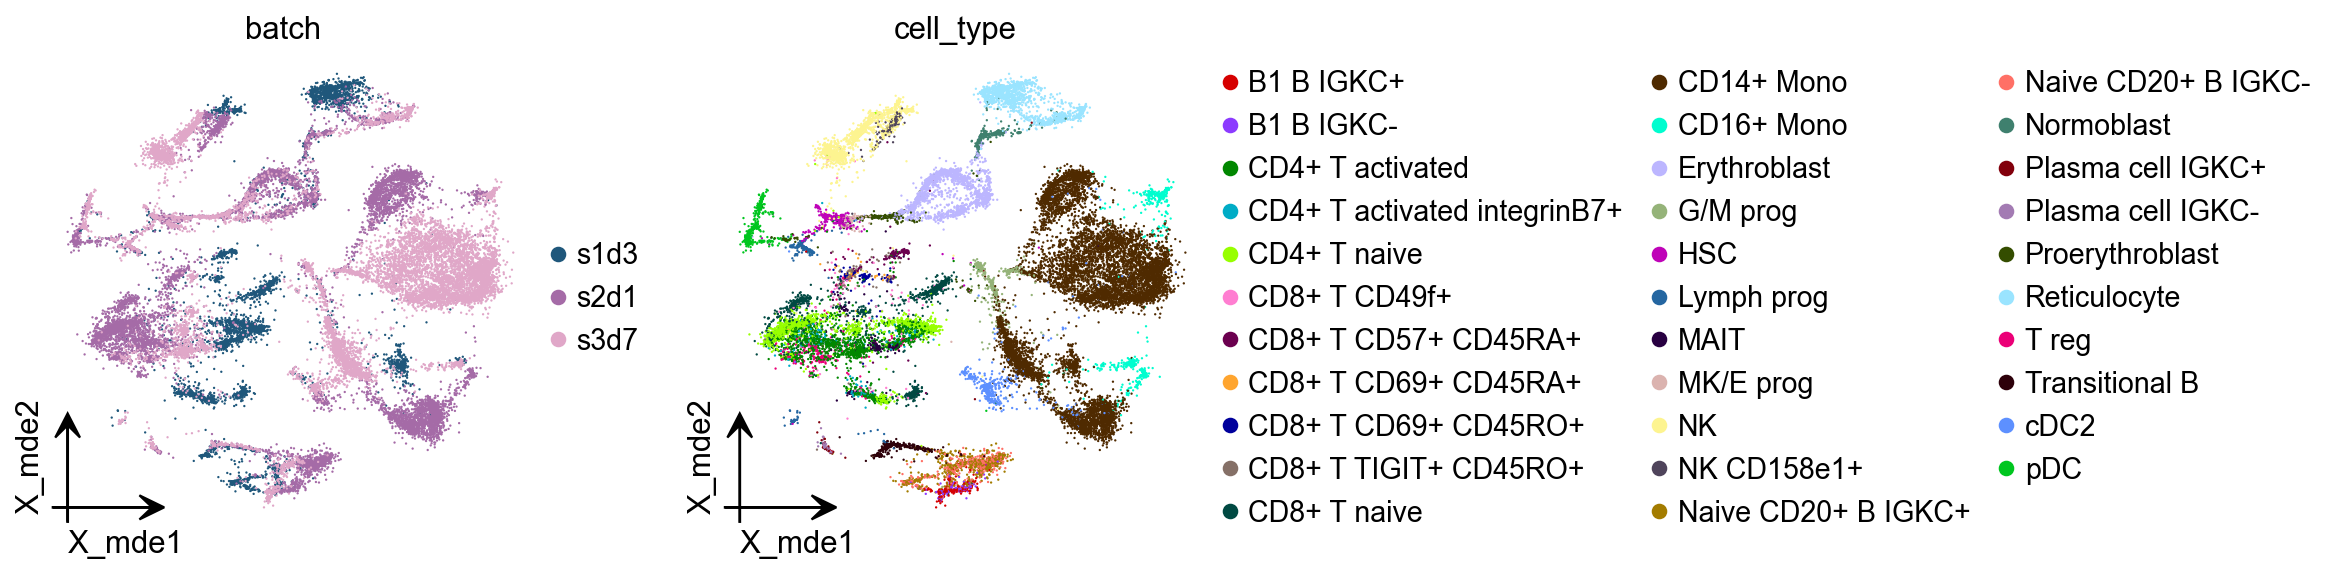

In [14]:
ov.pl.embedding(adata,
                basis='X_mde',frameon='small',
                color=['batch','cell_type'],show=False)

## Harmony

Harmony is an algorithm for performing integration of single cell genomics datasets. Please check out manuscript on [Nature Methods](https://www.nature.com/articles/s41592-019-0619-0).

![harmony](https://portals.broadinstitute.org/harmony/articles/main.jpg)

The function `ov.single.batch_correction` can be set in three methods: `harmony`,`combat` and `scanorama`

In [15]:
ov.single.batch_correction(
    adata,batch_key='batch',
    methods='harmony',n_pcs=50
)
adata

...Begin using harmony to correct batch effect

Using CUDA device: NVIDIA H100 80GB HBM3
✅ TorchDR available for GPU-accelerated PCA
   Omicverse mode: cpu
   Detected device: cuda
🖥️ Using PyTorch CPU acceleration for Harmony
🔍 [2026-01-07 13:58:37] Running Harmony integration...
    Max iterations: 10
    Convergence threshold: 0.0001


Harmony converged after 8 iterations:  70%|███████   | 7/10 [00:54<00:23,  7.72s/it]

✅ Harmony converged after 8 iterations


AnnData object with n_obs × n_vars = 27423 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'log1p', 'hvg', 'pca', 'status', 'status_args', 'REFERENCE_MANU', 'batch_colors_rgba', 'batch_colors', 'cell_type_colors_rgba', 'cell_type_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_co

In [16]:
adata.obsm["X_mde_harmony"] = ov.utils.mde(adata.obsm["X_pca_harmony"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>]

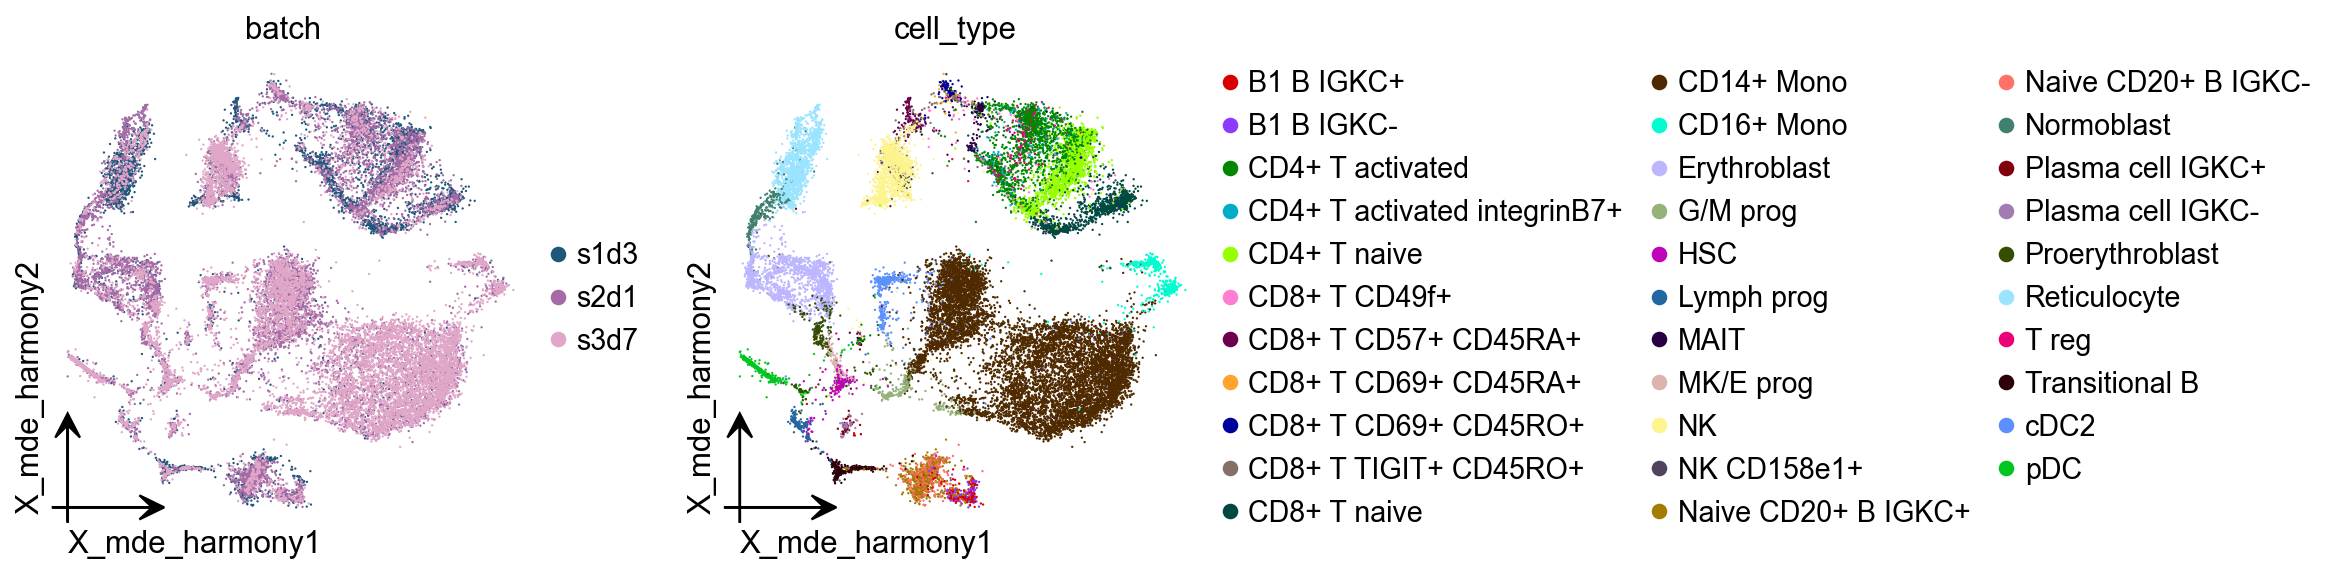

In [17]:
ov.pl.embedding(
    adata,
    basis='X_mde_harmony',frameon='small',
    color=['batch','cell_type'],show=False
)

## Combat

combat is a batch effect correction method that is very widely used in bulk RNA-seq, and it works just as well on single-cell sequencing data.



In [18]:
ov.single.batch_correction(
    adata,batch_key='batch',
    methods='combat',n_pcs=50
)

...Begin using combat to correct batch effect
Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

computing PCA🔍
    with n_comps=50
   🖥️ Using sklearn PCA for CPU computation
   🖥️ sklearn PCA backend: CPU computation
    finished✅ (0:00:22)


In [19]:
adata.obsm["X_mde_combat"] = ov.utils.mde(adata.obsm["X_combat"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_combat1', ylabel='X_mde_combat2'>]

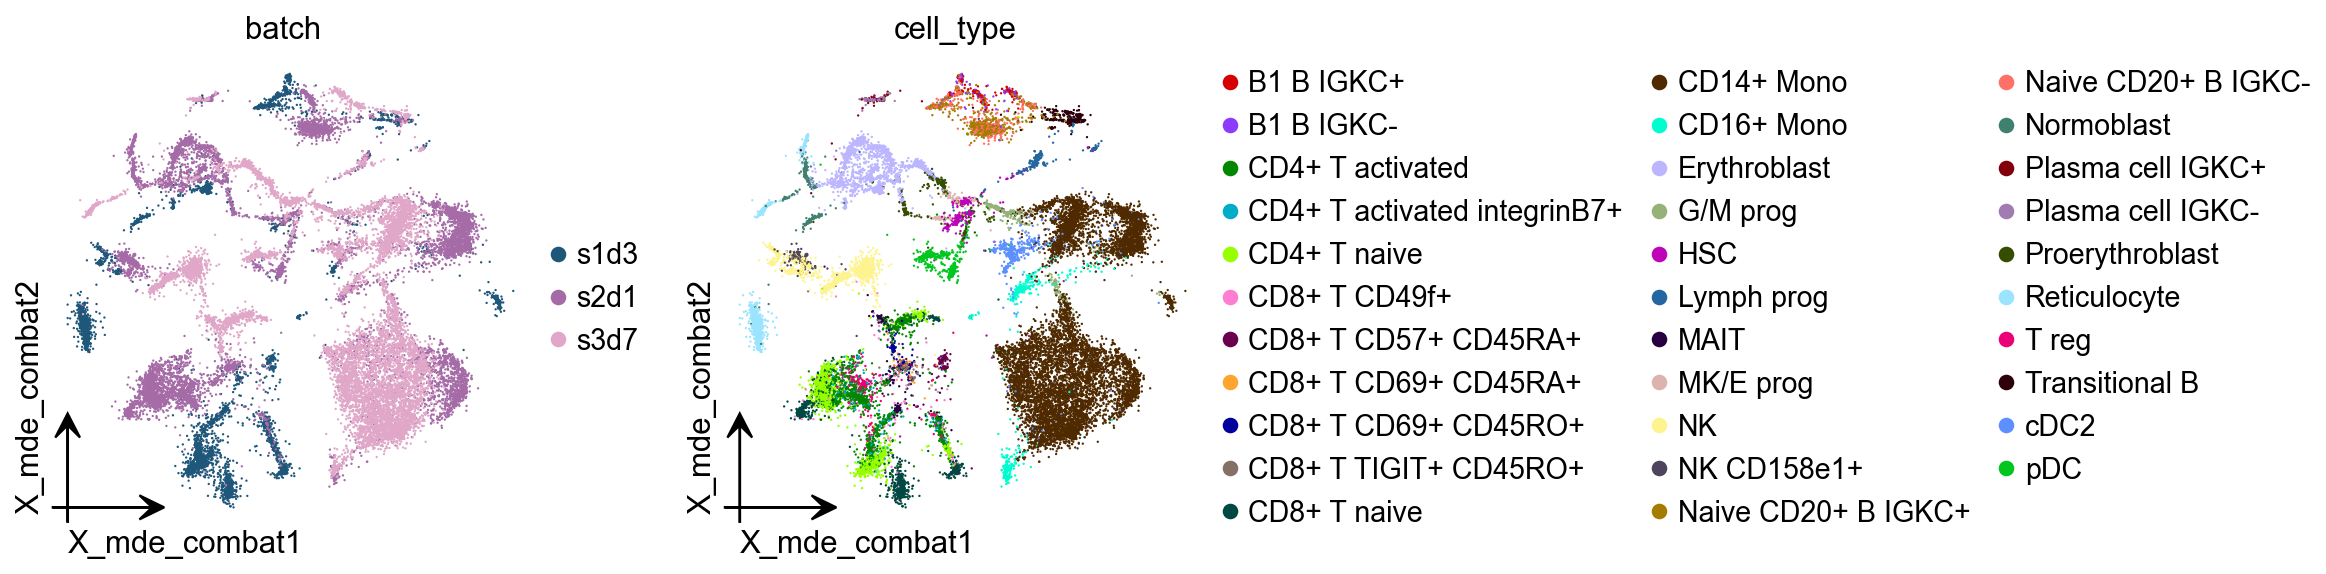

In [20]:
ov.pl.embedding(
    adata,
    basis='X_mde_combat',frameon='small',
    color=['batch','cell_type'],show=False
)

## scanorama

Integration of single-cell RNA sequencing (scRNA-seq) data from multiple experiments, laboratories and technologies can uncover biological insights, but current methods for scRNA-seq data integration are limited by a requirement for datasets to derive from functionally similar cells. We present Scanorama, an algorithm that identifies and merges the shared cell types among all pairs of datasets and accurately integrates heterogeneous collections of scRNA-seq data. 

![scanorama](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41587-019-0113-3/MediaObjects/41587_2019_113_Fig1_HTML.png?as=webp)

In [21]:
ov.single.batch_correction(
    adata,batch_key='batch',
    methods='scanorama',n_pcs=50
)

...Begin using scanorama to correct batch effect
s1d3
s2d1
s3d7
Found 3000 genes among all datasets
[[0.         0.51288964 0.56192081]
 [0.         0.         0.61815169]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (0, 1)
(27423, 50)


AnnData object with n_obs × n_vars = 27423 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'log1p', 'hvg', 'pca', 'status', 'status_args', 'REFERENCE_MANU', 'batch_colors_rgba', 'batch_colors', 'cell_type_colors_rgba', 'cell_type_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_co

In [22]:
adata.obsm["X_mde_scanorama"] = ov.utils.mde(adata.obsm["X_scanorama"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_scanorama1', ylabel='X_mde_scanorama2'>]

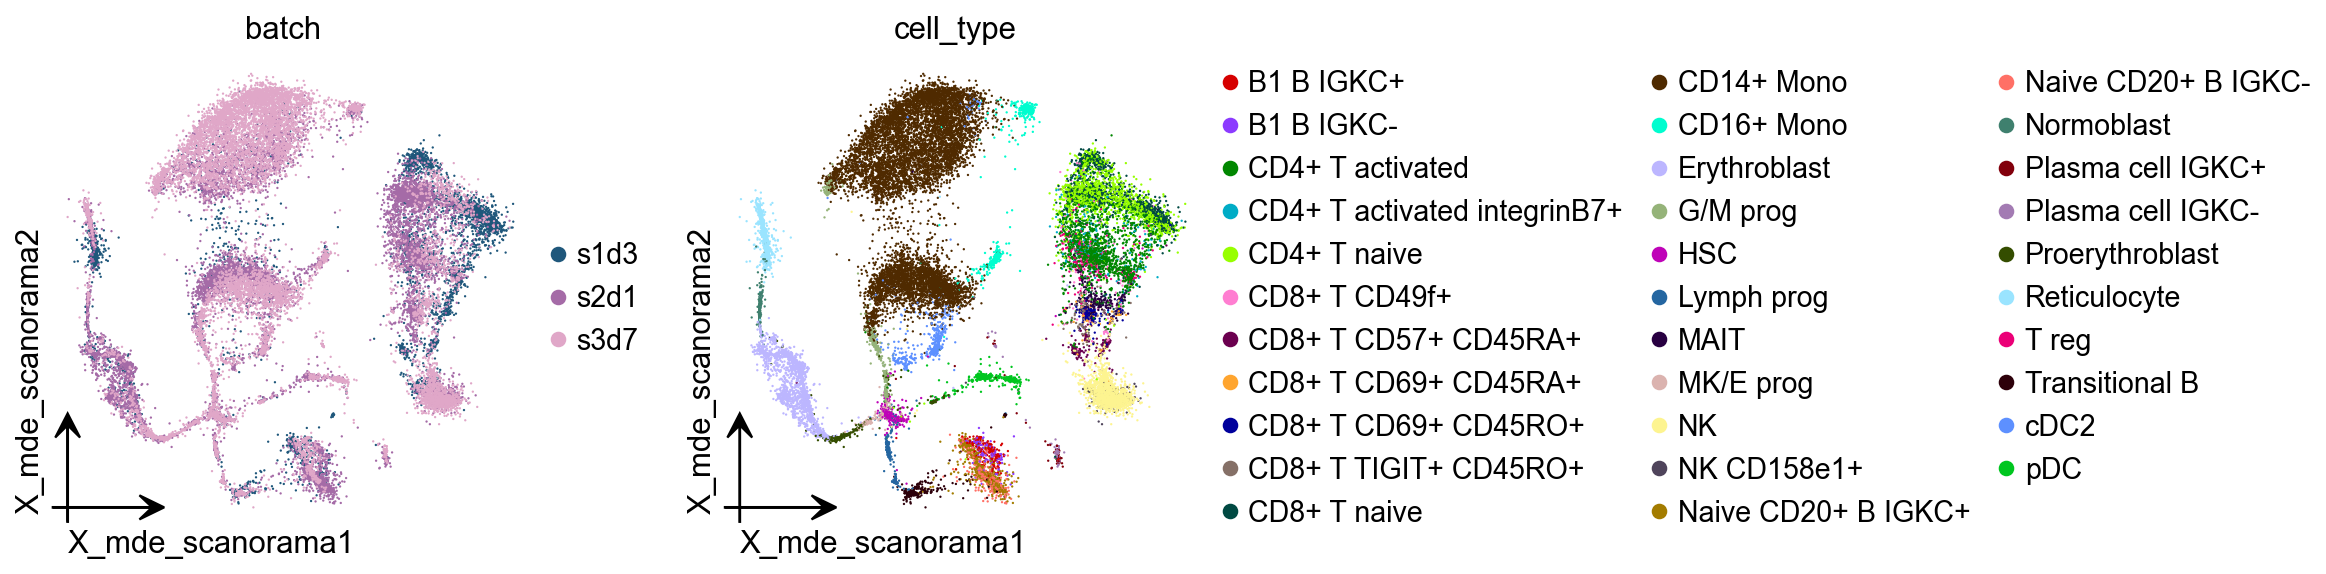

In [23]:
ov.pl.embedding(
    adata,
    basis='X_mde_scanorama',frameon='small',
    color=['batch','cell_type'],show=False
)

## scVI

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the scIB manuscript. The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

In [24]:
model=ov.single.batch_correction(
    adata,batch_key='batch',
    methods='scVI',n_layers=2, n_latent=30, gene_likelihood="nb"
)

...Begin using scVI to correct batch effect


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/292 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=292` reached.


In [25]:
adata.obsm["X_mde_scVI"] = ov.utils.mde(adata.obsm["X_scVI"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_scVI1', ylabel='X_mde_scVI2'>]

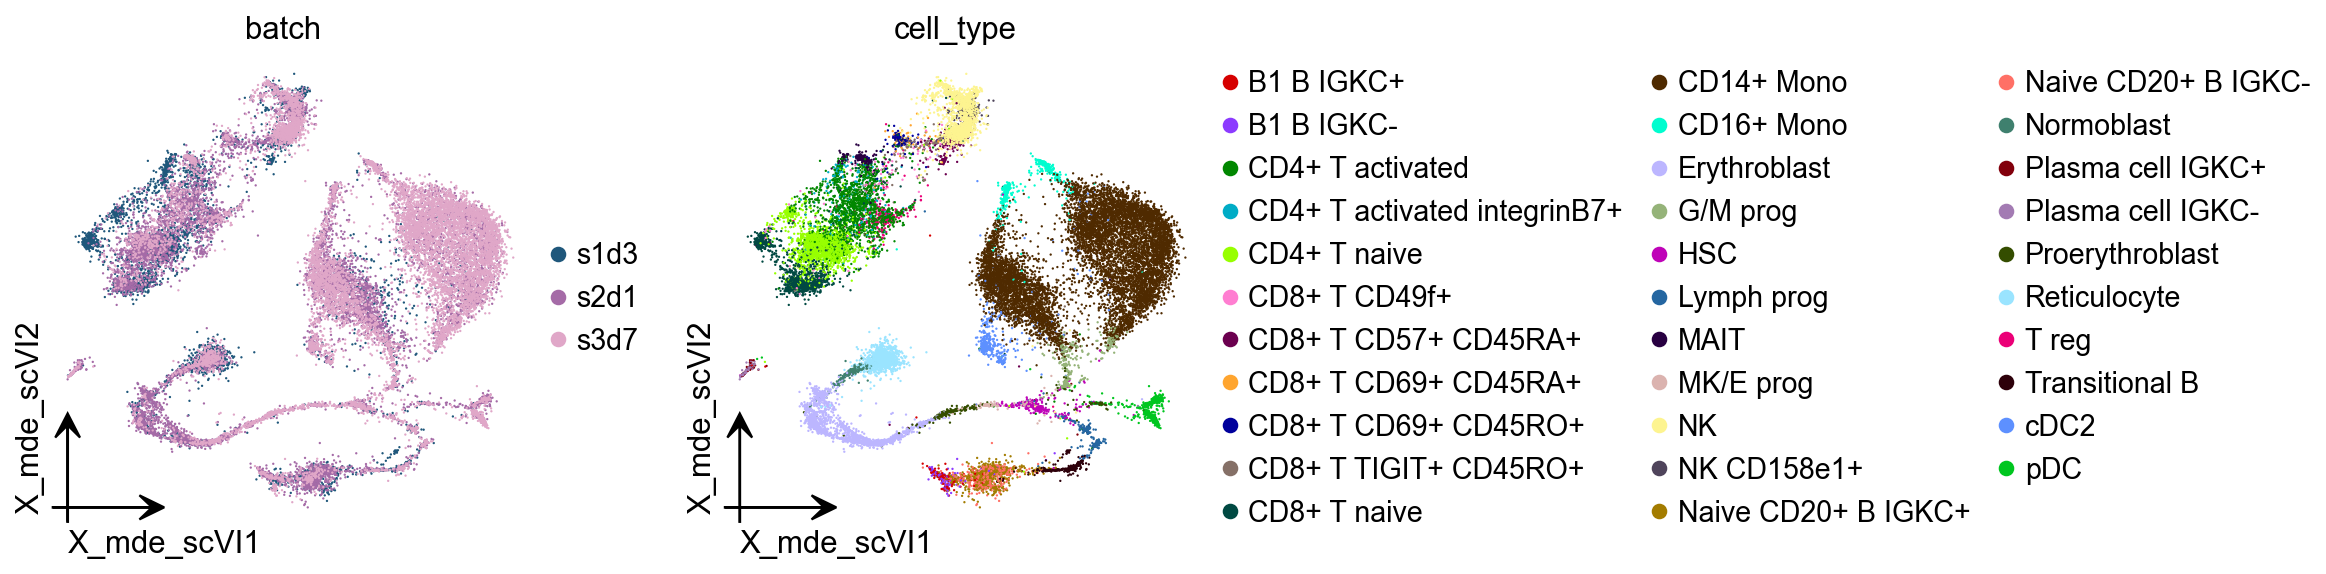

In [26]:
ov.pl.embedding(
    adata,
    basis='X_mde_scVI',frameon='small',
    color=['batch','cell_type'],show=False
)

## CellANOVA

The integration of cells across samples to remove unwanted batch variation plays a critical role in single cell analyses. When the samples are expected to be biologically distinct, it is often unclear how aggressively the cells should be aligned across samples to achieve uniformity. CellANOVA is a Python package for batch integration with signal recovery in single cell data. It builds on existing single cell data integration methods, and uses a pool of control samples to quantify the batch effect and separate meaningful biological variation from unwanted batch variation. When used with an existing integration method, CellAnova allows the recovery of biological signals that are lost during integration.

In omicverse, you only need to prepare the `control_dict`(At least two samples are required!) when you want to try `CellANOVA`. When you're done running it, there are two outputs you need to be aware of:

1. the first one being: `adata.layers['denoised']`, which stores the matrix after the batch effect is removed.
2. The second is `adata.obsm['X_mde_cellANOVA']`, which stores the low-dimensional representation of the cell after removing the batch effect

- Zhang, Z., Mathew, D., Lim, T.L. et al. Recovery of biological signals lost in single-cell batch integration with CellANOVA. Nat Biotechnol (2024). https://doi.org/10.1038/s41587-024-02463-1

In [27]:
## construct control pool
control_dict = {
    'pool1': ['s1d3','s2d1'],
}

ov.single.batch_correction(adata,batch_key='batch',n_pcs=50,
                           methods='CellANOVA',control_dict=control_dict)

...Begin using CellANOVA to correct batch effect
computing PCA
    with n_comps=70
    finished (0:00:08)


2026-01-07 14:07:16,179 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-01-07 14:07:19,645 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-01-07 14:07:19,712 - harmonypy - INFO - Iteration 1 of 30
2026-01-07 14:07:23,631 - harmonypy - INFO - Iteration 2 of 30
2026-01-07 14:07:27,554 - harmonypy - INFO - Iteration 3 of 30
2026-01-07 14:07:31,309 - harmonypy - INFO - Iteration 4 of 30
2026-01-07 14:07:35,219 - harmonypy - INFO - Iteration 5 of 30
2026-01-07 14:07:38,938 - harmonypy - INFO - Converged after 5 iterations


00%|██████████| 3/3 [00:01<00:00,  1.89it/s]

computing PCA🔍
    with n_comps=50
   🖥️ Using sklearn PCA for CPU computation
   🖥️ sklearn PCA backend: CPU computation
    finished✅ (0:00:50)


In [28]:
adata.obsm["X_mde_cellANOVA"] = ov.utils.mde(adata.obsm["X_cellanova"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_cellANOVA1', ylabel='X_mde_cellANOVA2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_cellANOVA1', ylabel='X_mde_cellANOVA2'>]

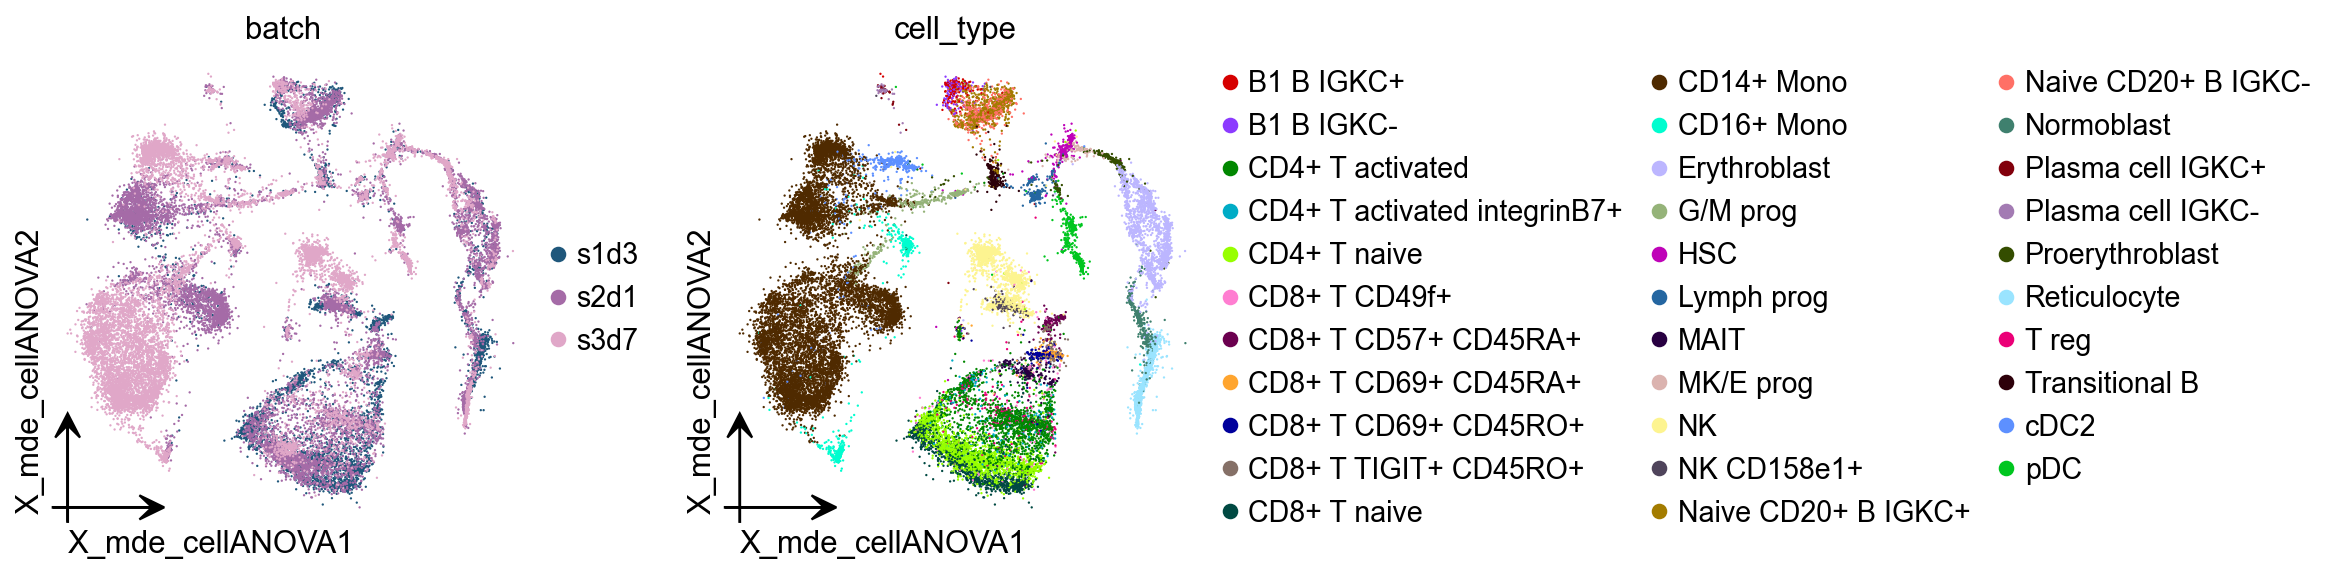

In [29]:
ov.pl.embedding(
    adata,
    basis='X_mde_cellANOVA',frameon='small',
    color=['batch','cell_type'],show=False
)

## CONCORD

Revealing the underlying cell-state landscape from single-cell data requires overcoming the critical obstacles of batch integration, denoising and dimensionality reduction. Here we present CONCORD, a unified framework that simultaneously addresses these challenges within a single self-supervised model. At its core, CONCORD implements a probabilistic sampling strategy that corrects batch effects through dataset-aware sampling and enhances biological resolution through hard-negative sampling. 

In omicverse, you only need to set the methods='Concord', and it will use concord to remove the batch effect automatically.

- Zhu, Q., Jiang, Z., Zuckerman, B. et al. Revealing a coherent cell-state landscape across single-cell datasets with CONCORD. Nat Biotechnol (2026).

In [10]:
ov.single.batch_correction(
    adata,batch_key='batch',
    methods='Concord',device='cuda'
)

...Begin using Concord to correct batch effect
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training


In [11]:
adata.obsm["X_mde_concord"] = ov.utils.mde(adata.obsm["X_concord"])

[<Axes: title={'center': 'batch'}, xlabel='X_mde_concord1', ylabel='X_mde_concord2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_mde_concord1', ylabel='X_mde_concord2'>]

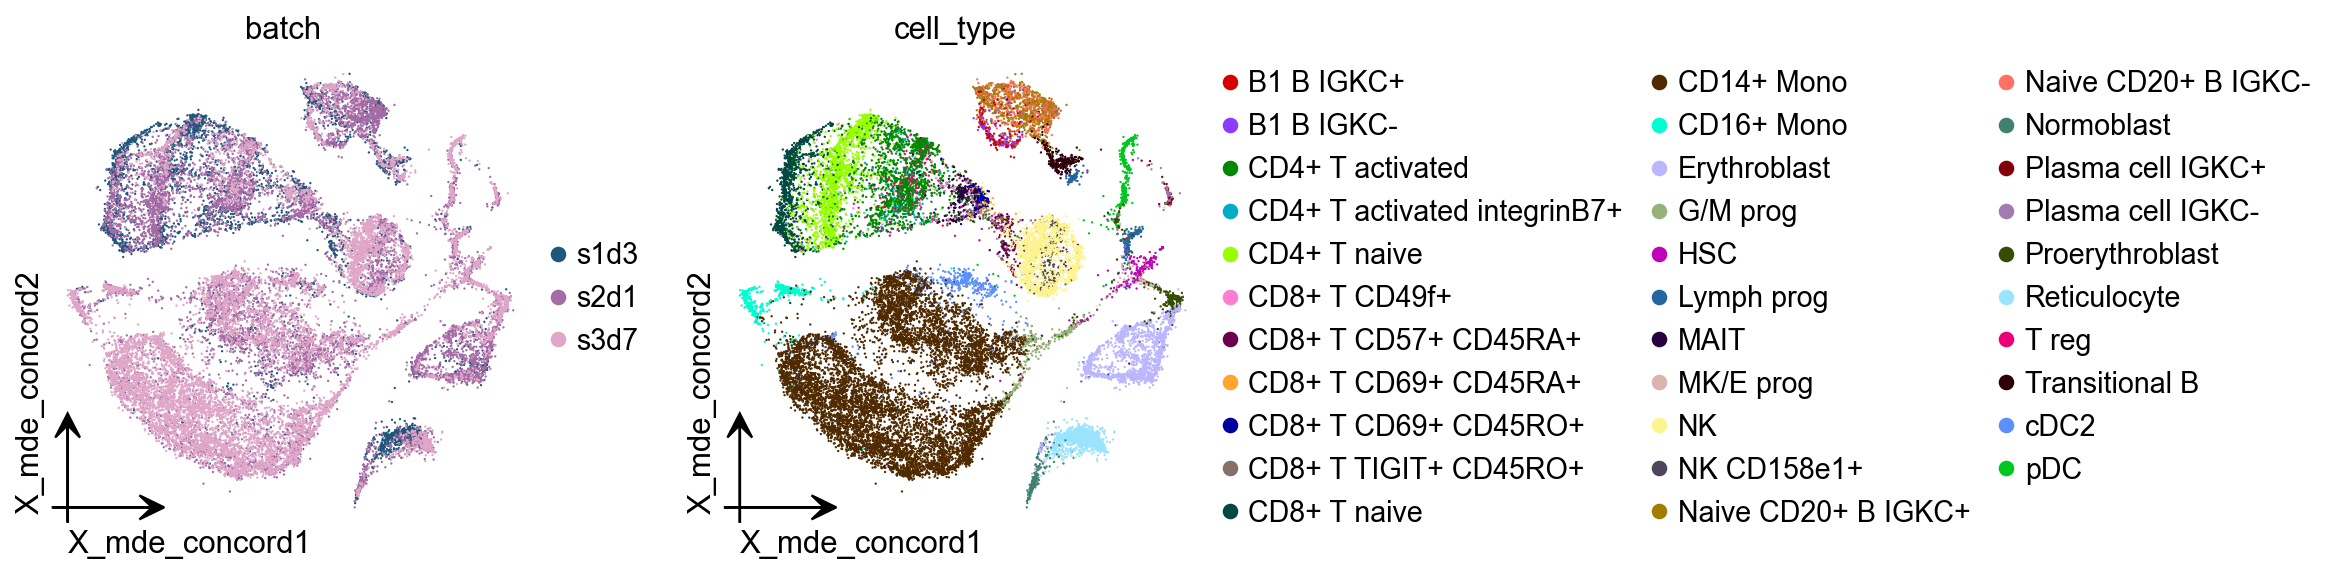

In [12]:
ov.pl.embedding(
    adata,
    basis='X_mde_concord',frameon='small',
    color=['batch','cell_type'],show=False
)

## Benchmarking test

The methods demonstrated here are selected based on results from benchmarking experiments including the single-cell integration benchmarking project [Luecken et al., 2021]. This project also produced a software package called [scib](https://www.github.com/theislab/scib) that can be used to run a range of integration methods as well as the metrics that were used for evaluation. In this section, we show how to use this package to evaluate the quality of an integration.

In [30]:
adata.write_h5ad('data/neurips2021_batch_all.h5ad',compression='gzip')

In [2]:
adata=ov.read('data/neurips2021_batch_all.h5ad')

In [3]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca'].copy()

In [4]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "X_combat", "X_pca_harmony",'X_cellanova',
                         'X_scanorama','X_concord','X_scVI',],
    n_jobs=8,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:11)

















rics:  60%|██████    | 6/10 [02:08<01:54, 28.64s/it, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             



















rics:  60%|██████    | 6/10 [00:01<00:01,  3.00it/s, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             


















rics:  60%|██████    | 6/10 [00:01<00:01,  3.11it/s, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             


















rics:  60%|██████    | 6/10 [00:01<00:01,  3.28it/s, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             


















rics:  60%|██████    | 6/10 [00:02<00:01,  3.04it/s, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             


















rics:  60%|██████    | 6/10 [00:14<00:15,  3.80s/it, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             


















rics:  60%|██████    | 6/10 [00:14<00:12,  3.23s/it, Batch correction: kbet_per_label]

INFO     32 clusters consist of a single batch or are too small. Skip.                                             








                                                                                      arison]

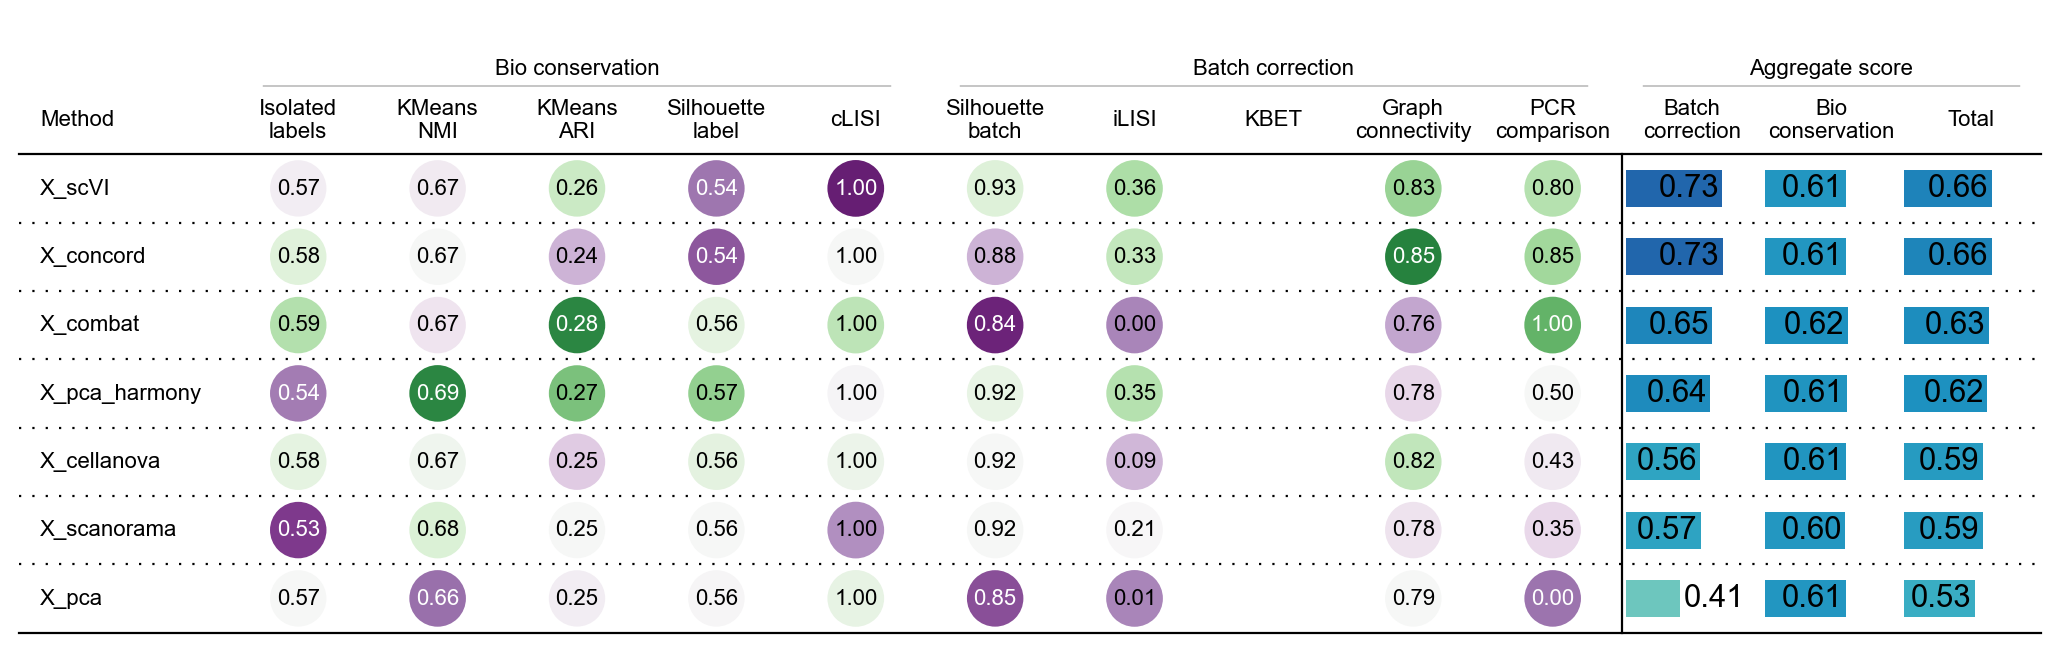

In [5]:
bm.plot_results_table(min_max_scale=False)

We can find that `harmony` removes the batch effect the best of the three methods that do not use the GPU, `scVI` and `CONCORD` is method to remove batch effect using GPU.